## Data processing for statistical figures 

In [39]:
# imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point


DATAFOLDER = 'data'
warnings.filterwarnings("ignore")

In [4]:
# read the .txt file and split the schedules by the separator '*Z '
with open(DATAFOLDER + "/2020_03_01/FPLAN") as schedules:
    text = schedules.read()
result = text.split('*Z ')

In [5]:
def int_list_time(a):
    l = []
    name = ''
    for i in a:
        if i.lstrip("-").isdigit():
            if len(i) == 5 or len(i) ==6:
                l.append(i)
        else:
            name += i
    return l, name           

In [6]:
# format the .txt file results
sch_number, route_number, transport_type, start_st_id, end_st_id, passing_st_ids, passing_st_names, st_arr_times, st_dep_times = ([] for i in range(9))
for i in result[1:]:    
    a = i.split('*')
    # get the identical information about schedule 
    schedule_id = a[0].split()
    route_number.append(schedule_id[0])
    sch_number.append(schedule_id[-2])
    # get the identical information about route 
    route_info = a[1].split()
    transport_type.append(route_info[1])
    start_st_id.append(route_info[2])
    end_st_id.append(route_info[3])
    st_id, station_name, arr_time, dep_time = ([] for i in range(4))
    # the route detail
    overall_sch = a[-1].split('%\n')[1:-1]
    for j in overall_sch:
        route = j.strip().split()
        st_id.append(route[0])
        time, station_name = int_list_time(route)
        arr_time.append(time[0])
        dep_time.append(time[-1])
    passing_st_ids.append(st_id)
    passing_st_names.append(station_name)
    st_arr_times.append(arr_time)
    st_dep_times.append(dep_time)

In [7]:
# making the dataframe from obtained lists 
data_dict = {'schedule_id': sch_number, 'route_number': route_number,'transport_type': transport_type,
            'start_station_ID': start_st_id,'end_station_ID': end_st_id, 'route_start_time': [time[0] for time in st_arr_times],
             'route_end_time': [time[-1] for time in st_dep_times],
            'passing_station_IDS': passing_st_ids,
            'passing_st_names': passing_st_names, 'arrival_times':st_arr_times, 'departure_times': st_dep_times}
data = pd.DataFrame.from_dict(data_dict)
data.head()

,schedule_id,route_number,transport_type,start_station_ID,end_station_ID,route_start_time,route_end_time,passing_station_IDS,passing_st_names,arrival_times,departure_times
0,12607908707,04700,RE,8014309,8014228,00447,00540,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00447, 00452, 00456, 00501, 00506, 00513, 005...","[00447, 00453, 00457, 00502, 00507, 00514, 005..."
1,12606485457,04701,RE,8014228,8014309,00456,00541,"[8014228, 8014241, 8014245, 8014277, 8014281, ...",Offenburg,"[00456, 00505, 00509, 00515, 00521, 00526, 005...","[00456, 00505, 00510, 00516, 00522, 00527, 005..."
2,12605476307,04702,RE,8014309,8014228,00546,00639,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00546, 00550, 00555, 00559, 00604, 00611, 006...","[00546, 00551, 00555, 00600, 00605, 00612, 006..."
3,12611010807,04703,RE,8014521,8014586,00551,00725,"[8014521, 8014529, 8014533, 8014534, 8014554, ...",Konstanz,"[00551, 00601, 00609, 00615, 00632, 00635, 006...","[00551, 00602, 00610, 00619, 00633, 00636, 006..."
4,12610946707,04704,RE,8014521,8014228,00535,00750,"[8014521, 8014518, 8014513, 8014511, 8014502, ...",KarlsruheHbf,"[00535, 00543, 00557, 00611, 00619, 00625, 006...","[00535, 00544, 00558, 00612, 00621, 00626, 006..."


In [21]:
# format the date
data.route_start_time = abs(data.route_start_time.astype(int)/100)%24
data.route_end_time = abs(data.route_end_time.astype(int)/100)%24

In [22]:
print("The number of available schedules until 2020 March 1st for a day in Switzerland: {}".format(data.shape[0]))

The number of available schedules until 2020 March 1st for a day in Switzerland: 473233


## Prepare the data for D3. force

In [9]:
def create_links(passing_st_ids):
    """Create the dict of links with frequency values"""
    links = []
    info = {}
    for i in range(len(passing_st_ids)):
        sorted_ids = sorted(passing_st_ids[i]) 
        for j in range(len(sorted_ids)):
            for k in range(j+1, len(sorted_ids)):
                info = {}
                info['source'] = sorted_ids[j]
                info['target'] = sorted_ids[k]
                info['value'] = 1
                links.append(info)
    return links
links = create_links(passing_st_ids)
a = pd.DataFrame.from_dict(links)
d = a.groupby(['source','target'])['value'].sum().reset_index()
d.to_csv(DATAFOLDER + '/links.csv')

In [134]:
d.to_csv(DATAFOLDER + '/data_figures/links.csv', index=False)

## Prepare data for Time Radial Histogram

In [24]:
print("The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: {}".format(time_data.shape[0]))


The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: 458881


In [25]:
time_data.head()

,route_number,transport_type,route_start_time,route_end_time
0,04700,RE,4.47,5.40
1,04701,RE,4.56,5.41
2,04702,RE,5.46,6.39
3,04703,RE,5.51,7.25
4,04704,RE,5.35,7.50


In [26]:
def decompose_time(start_time, end_time, interval_fr = 1):
    """interval_fr = {1, 2} in every 1 hour or 30 mins"""
    sc_start_time = []
    sc_start_time.append(start_time)
    a_0 = (1/interval_fr) * (np.floor(interval_fr * start_time) + 1)
    a_n = (1/interval_fr) * (np.floor(interval_fr * end_time))
    while(a_0 < a_n):
        sc_start_time.append(a_0)
        a_0 += 1/interval_fr
    if(int(start_time) != int(end_time)): 
        sc_start_time.append(end_time)
    return sc_start_time
print(decompose_time(start_time = 7.60, end_time = 12.5, interval_fr = 2))

[7.6, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5]


In [27]:
a = [time_data.route_start_time.tolist(), time_data.route_end_time.tolist()]

In [29]:
collect = []
for i in range(len(a[0])):
    times = decompose_time(a[0][i], a[1][i], interval_fr = 1)
    collect.append(times)
    
flat_list = [item for sublist in collect for item in sublist]

In [135]:
time = pd.DataFrame(flat_list, columns=['time_bin_1_hour'])
time.to_csv(DATAFOLDER +'/data_figures/time_bin_1_hours.csv', index=False)

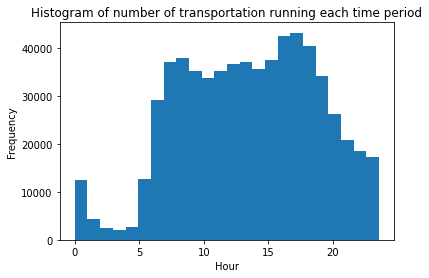

In [37]:
n, bins, patches = plt.hist(flat_list, bins = 24)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Histogram of number of transportation running each time period')
plt.show()

## Prepare the data for Stacked Barchart

In [83]:
# load GeoJSON file containing sectors
with open(DATAFOLDER + '/dd_geojson_switzerland.json') as f:
    js = json.load(f)
    
# construct point based on lon/lat returned by geocoder
point = Point(8.446594, 47.276070)
def get_canton(js, lat, long):
    point = Point(lat, long)
   # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'not in switzerland'
get_canton(js, 7.655224, 47.597713)

'not in switzerland'

In [41]:
# prepare data for stacked barchart
st, rn, tt, at, dt   = ([] for i in range(5))
for ix1, st_ids in enumerate(passing_st_ids):
    for ix2, st_id in enumerate(st_ids):
        st.append(st_id)
        rn.append(route_number[ix1])
        tt.append(transport_type[ix1])
        at.append(st_arr_times[ix1][ix2])
        dt.append(st_dep_times[ix1][ix2])      

In [42]:
# making the dataframe from obtained lists 
tr_res_dict = {'station_id': st, 'route_number': rn,'transport_type': tt
              # ,'arrival_time': at,'sep_time': dt
              }
tr_res = pd.DataFrame.from_dict(tr_res_dict)
tr_res.drop_duplicates(inplace=True)
tr_res.head()

,station_id,route_number,transport_type
0,8014309,04700,RE
1,8014289,04700,RE
2,8014288,04700,RE
3,8014283,04700,RE
4,8014281,04700,RE


In [43]:
# map into several transport types 
trains = ['ICE', 'TGV', 'RJ', 'EC', 'IC', 'IR', 'PE', 'RE', 'S', 'SN', 'R', 'ARZ', 'EXT', 'NJ', 'IRE','RJX', 'RB', 'CC','TER']
fun = ['FUN', 'PB']
metro = ['M']
bus = ['B', 'CAR', 'EXB']
ship = ['BAT']
tram = ['T', 'TE2']
lift = ['GB', 'ASC']
other = ['SL', 'BN', 'FAE', 'RUB', 'KB','BP', 'EN']

tr_types = ['train','fun','metro','bus','ship','tram']
tr_res['transport_type'][tr_res.transport_type.isin(trains)] = 'train'
tr_res['transport_type'][tr_res.transport_type.isin(fun)] = 'fun'
tr_res['transport_type'][tr_res.transport_type.isin(metro)] = 'metro'
tr_res['transport_type'][tr_res.transport_type.isin(bus)] = 'bus'
tr_res['transport_type'][tr_res.transport_type.isin(ship)] = 'ship'
tr_res['transport_type'][tr_res.transport_type.isin(tram)] = 'tram'
tr_res['transport_type'][tr_res.transport_type.isin(lift)] = 'lift'
tr_res['transport_type'][tr_res.transport_type.isin(other)] = 'other'

Text(0.5, 0, 'Number of schedules for different route types')

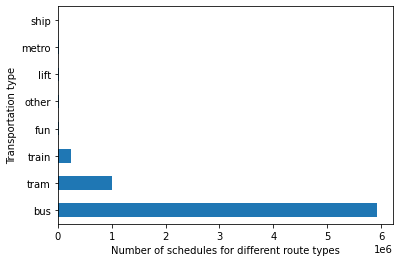

In [20]:
ax = tr_res.transport_type.value_counts()[:10].plot.barh(legend=False)
ax.set_ylabel('Transportation type')
ax.set_xlabel('Number of schedules for different route types')

In [56]:
with open(DATAFOLDER + "/2020_03_01/BFKOORD_GEO") as stations:
    text = stations.read()
result = text.split('\n')
st_id, lat, longt, number, name = ([] for i in range(5))
for i in range(len(result) - 1):
    each = result[i].split()
    st_id.append(each[0])
    lat.append(each[1])
    longt.append(each[2])
    number.append(each[3])
    name.append(' '.join(each[5:])) 
station_info = {'station_id': st_id, 'latitude': lat,'longitude': longt
               ,'number': number,'station_name': name}
stations = pd.DataFrame.from_dict(station_info)

In [72]:
stations.latitude= stations.latitude.astype(float)
stations.longitude= stations.longitude.astype(float)

In [101]:
stations['canton'] = stations.apply(lambda row: get_canton(js, row.latitude, row.longitude), axis = 1)

In [108]:
suisse_stations = stations[stations.canton != 'not in switzerland']

In [112]:
station_name_id_map = pd.merge(tr_res, suisse_stations, how='inner', left_on='station_id', right_on='station_id')

In [115]:
print(tr_res.shape)
print(station_name_id_map.shape)

(7268827, 3)
(7016491, 8)


In [120]:
canton_tt_data = station_name_id_map.groupby(['canton', 'transport_type']).size().reset_index(name='counts')

In [133]:
canton_tt_data.to_csv(DATAFOLDER + '/data_figures/t_types_per_canton.csv', index=False)

In [136]:
canton_tt_data.head()

,canton,transport_type,counts
0,Aargau,bus,212358
1,Aargau,other,398
2,Aargau,ship,144
3,Aargau,train,16110
4,Appenzell Ausserrhoden,bus,16913
